# 分位数去极值

如果按照quantile有可能会将低于0很多的数据初始化为接近0的值


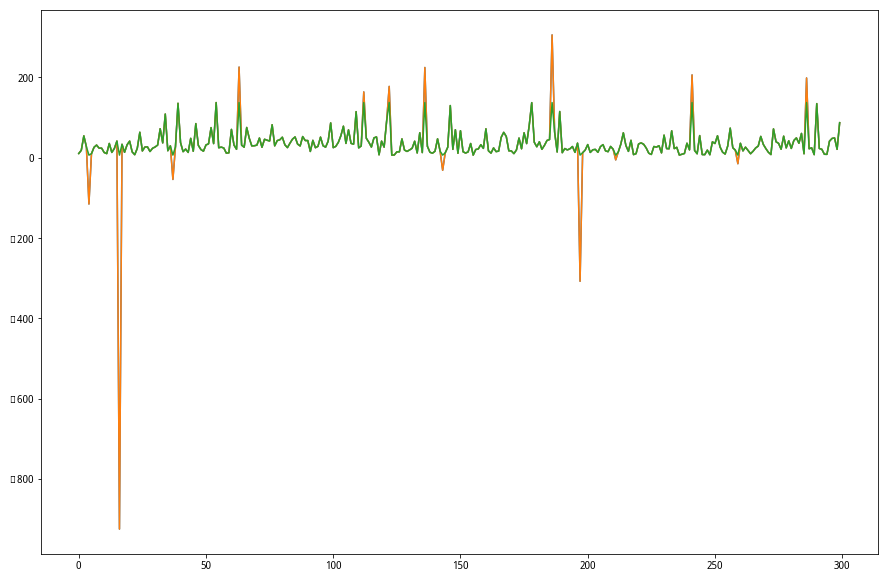

In [62]:
from scipy.stats.mstats import winsorize


date='2018-01-25'

stock = get_index_stocks('000300.XSHG',date)

q = query(valuation.code,
        valuation.pe_ratio,
        valuation.market_cap
        ).filter(valuation.code.in_(stock))


factor = get_fundamentals(q,date=date)


factor['pe_ratio'][:1000].plot()

# 百分位去极值
# 将2.5%分位数以下的值，替换
# 将97.5%分位数以上的值，替换
factor['pe_ratio1'] = winsorize(factor['pe_ratio'], limits=0.025)

factor['pe_ratio'][:1000].plot(figsize = (15,10))
factor['pe_ratio1'][:1000].plot(figsize = (15,10))

In [63]:
factor.head()

,code,pe_ratio,market_cap,pe_ratio1
0,000001.XSHE,10.5857,2438.1985,10.5857
1,000002.XSHE,18.6059,4437.7393,18.6059
2,000008.XSHE,54.5322,232.7940,54.5322
3,000060.XSHE,27.5143,281.2912,27.5143
4,000063.XSHE,-115.2650,1511.8774,6.5799


自实现分位数去极值

In [64]:
import numpy as np
# 自实现分位数法去极值
def quantile(factor,up,down):
    # 分位数去极值
    up_scale = np.percentile(factor, up)
    down_scale = np.percentile(factor, down)
    factor = np.where(factor > up_scale, up_scale, factor)
    factor = np.where(factor < down_scale, down_scale, factor)
    return factor

# 中位数绝对偏差去极值

1. 找出因子的中位数 median
2. 得到每个因子值与中位数的绝对偏差值 |x – median|
3. 得到绝对偏差值的中位数， MAD，median(|x – median|)
4. 计算MAD_e = 1.4826*MAD，然后确定参数 n，做出调整

中位数算法能够体现低值的趋势，较为合理

In [65]:
import numpy as np

def mad(factor):
    # 3倍中位数去极值
  
    # 求出因子值的中位数
    med = np.median(factor)

    # 求出因子值与中位数的差值，进行绝对值
    mad = np.median(abs(factor - med))

    # 定义几倍的中位数上下限
    high = med + (3 * 1.4826 * mad)
    low = med - (3 * 1.4826 * mad)

    # 替换上下限以外的值
    factor = np.where(factor > high, high, factor)
    factor = np.where(factor < low, low, factor)
    return factor


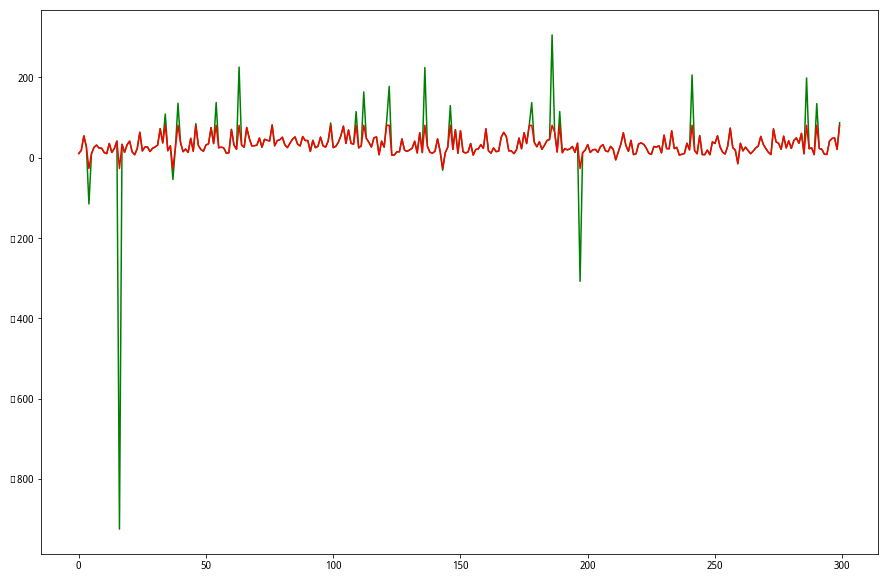

In [66]:
# 进行中位数去极值
factor['pe_ratio2'] = mad(factor['pe_ratio'])
# 显示
factor['pe_ratio'][:500].plot(figsize = (15,10), color='g')
factor['pe_ratio2'][:500].plot(figsize = (15,10), color='r')

# 正态分布去极值


In [67]:
# 3sigma原则
def three_sigma(factor):
    # 求出因子数据的平均值和标准差
    mean = factor.mean()
    
    std = factor.std()
    # 左右的数据加减3个标准差
    
    high = mean + (3 * std)
    low = mean - (3 * std)

    # 替换极值数据
    factor = np.where(factor > high, high, factor)
    factor = np.where(factor < low, low, factor)

    return factor

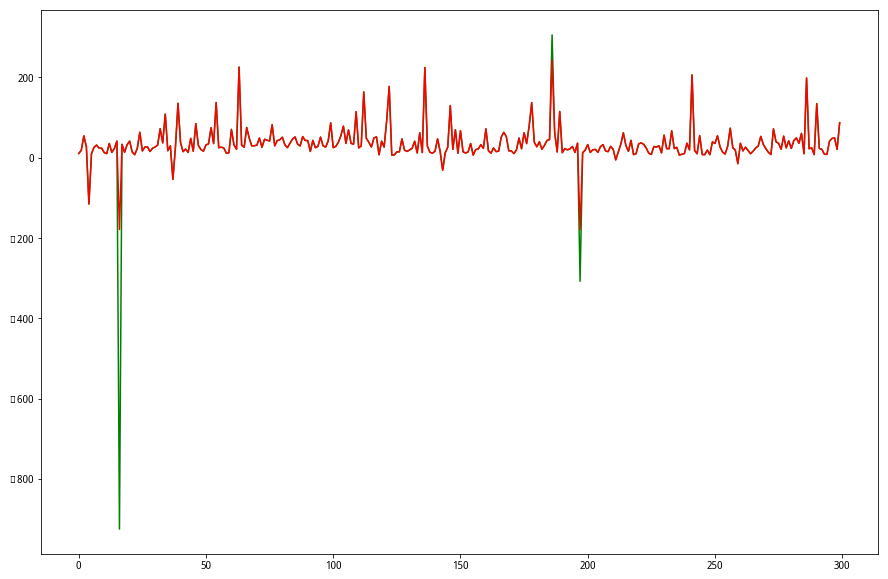

In [68]:
# 进行3sigma去极值
factor['pe_ratio3'] = three_sigma(factor['pe_ratio'])

factor['pe_ratio'][:500].plot(figsize = (15,10),color='g')
factor['pe_ratio3'][:500].plot(figsize = (15,10),color='r')

# 在做去极值处理的时候最好不要使用正态分布去极值法，推荐使用分位数和中位数绝对偏差去极值



# 因子数据处理-标准化

将不同量纲的因子统一化

标准化：实际就是偏离平局值的程度

In [69]:
# 这个sklearn.preprocessing 值得学习

from sklearn.preprocessing import StandardScaler
std = StandardScaler()
std.fit_transform(factor['pe_ratio2'])

ValueError: Expected 2D array, got 1D array instead:
array=[10.5857 18.6059 54.5322 27.5143 -26.886898640000002 10.0896 25.9993
 31.6253 23.9679 23.866999999999997 13.0485 10.3522 35.6133 13.3277
 23.1143 41.5648 -26.886898640000002 33.5216 13.5776 32.3435 41.4497
 14.5679 7.5978 23.5239 63.5363 16.9581 26.7212 27.2413 15.5668 23.6121
 26.8052 31.5416 72.4101 37.0082 80.91709864 17.5338 29.6481
 -26.886898640000002 27.0305 80.91709864 37.749 15.1361 21.6525 13.3118
 48.3451 16.2345 80.91709864 30.8262 20.5024 16.3588 31.9383 34.6671
 75.1009 35.284 80.91709864 24.9964 26.4338 24.2837 11.4594 12.3665 70.635
 31.7791 21.1339 80.91709864 31.3738 26.2153 75.4288 48.6924 29.5735
 29.9922 31.3739 49.1692 26.0896 46.0377 43.6829 41.8054 80.91709864
 29.6981 42.7529 44.7891 51.2241 32.2929 25.2601 36.2363 46.4332 51.9399
 34.0977 29.4267 52.8078 42.9308 42.8465 15.7433 43.3876 25.0485 28.4354
 51.3962 29.9361 26.4033 41.1678 80.91709864 25.1929 28.3329 38.2589
 54.7954 78.6637 35.777 69.5271 35.8757 33.8448 80.91709864 24.6101
 29.4016 80.91709864 48.6035 38.5978 26.6893 49.4547 51.989 7.3867 41.4158
 26.5046 80.91709864 80.91709864 6.6351 6.9282 14.7645 14.7887 46.9647
 19.1663 15.7806 19.4675 23.6079 41.2191 12.0113 62.3122 12.9288
 80.91709864 28.5627 13.6948 11.3957 16.2761 47.1698 16.4602
 -26.886898640000002 12.1446 26.2999 80.91709864 20.9349 69.8802 11.1684
 67.4001 15.0039 11.7983 14.5171 35.4925 6.5799 20.5488 21.9117 32.565
 23.3646 72.1024 17.1821 11.538 24.5472 15.3633 16.4851 50.8654 63.3845
 53.0144 17.3393 17.0401 10.3337 19.5513 49.0274 22.4201 62.1767 35.2965
 79.596 80.91709864 38.664 27.3354 39.866 21.0828 30.9189 43.1121 45.4639
 80.91709864 64.0759 14.4326 80.91709864 12.6815 22.9658 19.5603 22.3185
 28.0378 13.487 36.4515 -26.886898640000002 12.5712 18.9946 32.8311
 13.2439 19.9034 20.8539 13.5623 27.5853 32.7171 17.1719 15.1734 28.2665
 21.183000000000003 -5.2661 14.3172 33.6762 62.1475 30.6661 15.9152
 43.4494 7.8551 10.1562 34.4772 37.0202 33.5105 24.17 11.2231 8.2382
 28.0015 26.5055 30.006999999999998 12.1845 56.2976 22.8791 22.4678
 67.1075 22.9178 26.0031 6.7279 8.7736 10.6397 36.1641 19.7027 80.91709864
 18.0457 10.0032 55.2381 8.0156 7.7698 19.0615 7.5176 39.6611 35.4985
 54.7447 26.9997 13.9147 9.2416 28.9244 73.7961 25.1295 18.9833 -14.833
 36.0409 17.1589 26.4045 18.2338 10.0723 16.428 24.5146 29.0254 53.1857
 33.3349 22.8237 13.6373 8.0095 71.9239 39.8236 35.9084 21.2459 53.7664
 24.6344 42.2185 23.2798 42.9183 49.4705 36.1997 60.6142 9.9851
 80.91709864 22.4992 24.711 7.7766 80.91709864 23.1018 21.104 8.6986
 8.4943 41.3933 48.1044 49.4357 20.9781 80.91709864].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [70]:
def stand(factor):
    mean = factor.mean()
    std = factor.std()
    return (factor - mean)/std

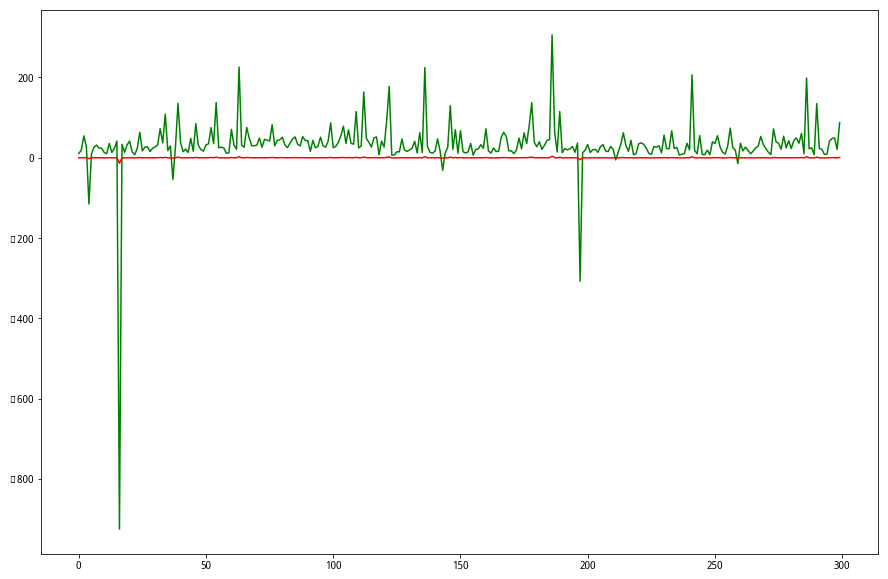

In [71]:
# 标准化
# 从标准化来看，量纲大大缩小
factor['pe_ratio4'] = stand(factor['pe_ratio'])

factor['pe_ratio'][:500].plot(figsize = (15,10),color='g')
factor['pe_ratio4'][:500].plot(figsize = (15,10),color='r')

# 中性化处理

市值中性化是为了在因子选股回测的时候，防止选到的股票集中在固定的某些股票当中。

默认大部分因子当中都包含了市值的影响，所以当我们通过一些指标选择股票的时候，每个因子都会提供市值的因素，是的选择的股票比较集中，也就是选股的标准不太好。

通过拟合找到x,y的关系公式，预测的时候会出现偏差？这个偏差是什么？

这个偏差即为保留下来的某因子除去市值影响的部分

- 获取两个因子数据
- 对目标值因子-市净率进行去极值、标准化处理
- 建立市值与市净率回归方程
- 通过回归系数，预测新的因子结果y_predict
- 求出市净率与y_predict的偏差即为新的因子值

In [72]:
date='2018-01-25'

stock = get_index_stocks('000300.XSHG',date)

q = query(valuation.code,
        valuation.pb_ratio,
        valuation.market_cap
        ).filter(valuation.code.in_(stock))


factor = get_fundamentals(q,date=date)

factor.head()

,code,pb_ratio,market_cap
0,000001.XSHE,1.2304,2438.1985
1,000002.XSHE,3.8134,4437.7393
2,000008.XSHE,3.7286,232.7940
3,000060.XSHE,2.8459,281.2912
4,000063.XSHE,4.8982,1511.8774


In [73]:
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm

# 先对pb_ratio进行去极值标准化处理
factor['pb_ratio'] = mad(factor['pb_ratio'])
factor['pb_ratio'] = stand(factor['pb_ratio'])

# 确定回归的数据
# x：市值
# y : 因子数据

# reshape -1 表示函数自身也不知道有多少行，自动按照X列（第二个参数）的要求排列

# 根据LinearRegression的要求需要将参数做reshape的处理
# python 3 在这里有一错误，所以要增加values的设置
x = factor['market_cap'].values.reshape(-1,1)

y = factor['pb_ratio']

# 建立回归方程并预测
lr = LinearRegression()
lr.fit(x, y)
y_predict = lr.predict(x)

# 去除线性的关系，留下误差作为该因子的值
factor['pb_ratio'] = y - y_predict

# 因子分析

核心就是下面两张表：

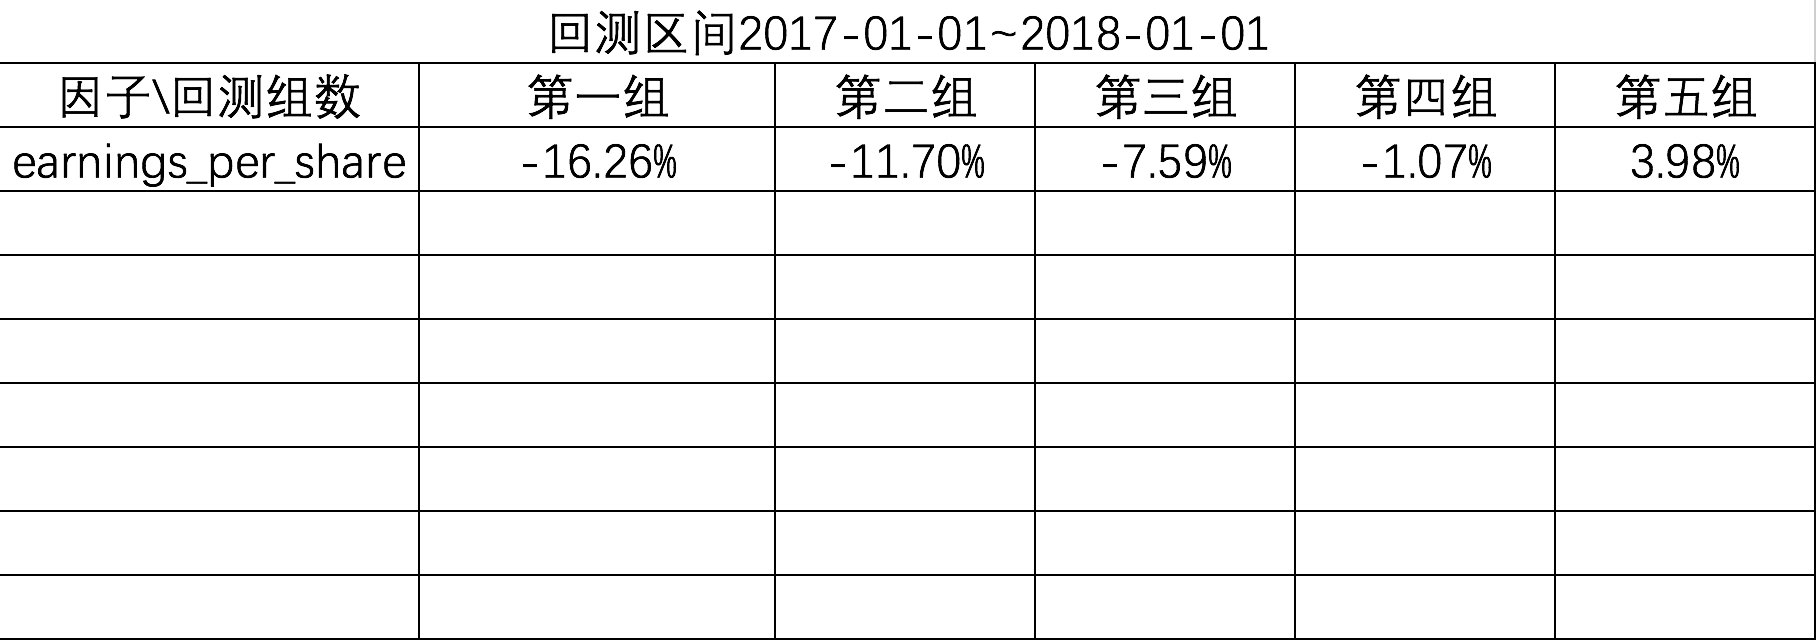

# 因子筛选

IC分析

某一期的IC指的是该期因子暴露值和股票下期的实际回报值在横截面上的相关系数
- IC mean：因子IC的平均值
- IC std：因子IC的标准差
- IC > 0.02：因子IC大于0.02的比例这里大于0.02可修改，如果更大，那么意味着筛选更加严格
- IR ： 信息比率
- 因子IR（信息比率）代表因子在历史上表现的稳定性。 IR = IC均值/IC的波动率。 因子在不同的历史时期的表现有可能差别很大， 有的时候表现很好， 有的时候表现很差，表现在IC上，就是IC的波动率很大。 假设IC均值一定， IC的波动率越小，因子表现越稳定，IR就越大 。
- IR > 0.3进行筛选，可以修改标准




alphalen 解释：

http://www.bat666.cn/book/trade/day03/section3.html

- 获取综合信息

    alphalens.tears.create_summary_tear_sheet(factor_data, long_short=True, group_neutral=False)

    一个简易的summary包含几种综合分析


- 因子IC 分析

    alphalens.performance.factor_information_coefficient(factor_data, group_adjust=False, by_group=False)

    计算因子值和预期收益之间的基于Spearman等级相关的信息系数（IC）(默认每天)

    返回IC dataframe

    factor_data:按日期（级别0）和资产（级别1）索引的MultiIndex DataFrame，包含单个alpha因子的值，每个期间的正向收益

    group_adjust: 是否行业分组

    by_group: 分组计算

    return: ic DataFrame
    

- alphalens.tearse.factor_alpha_beta(factor_data, returns=None, demeaned=True, group_adjust=False, equal_weight=False)
    
    计算alpha和beta


- alphalens.tears.create_information_tear_sheet
    
    因子收益率系数分析


- alphalens.tears.create_returns_tear_sheet(factor_data, long_short=True,group_neutral=False, by_group=False)

# alphalen常用函数

因子IC分析确定的是因子和收益率之间的相关系数

utils.get_clean_factor_and_forward_returns进行因子收益率和因子数据准备

performance.factor_information_coefficient计算因子的IC值

plotting.plot_ic_ts(IC)对IC序列进行移动平均图绘制

plotting.plot_ic_hist(IC)对IC序列进行直方图绘制

# 因子收益率

因子收益率是在固定周期内对因子暴露值和下期的收益率之间建立横截面回归方程。得到的权重系数即为因子收益率


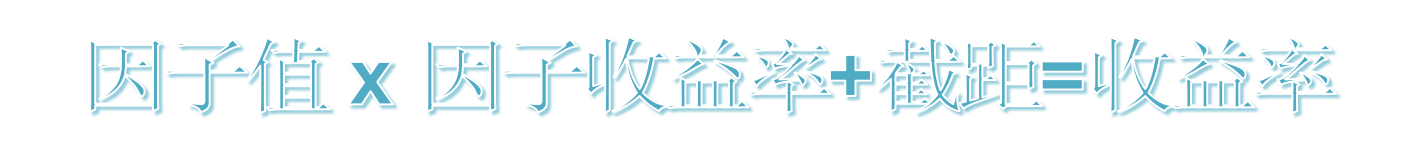

# 多因子相关性计算（实际就是对IC序列进行分析）

相关性分析还是使用斯皮尔曼秩相关系数，但是对象是两个因子的IC值序列分析

这里我们使用同一个因子类别下的return_on_equity和fully__diluted_earnings_per_share计算相关性

In [74]:
st.spearmanr(IC_return_on_equity.iloc[:, 0], IC_fully__diluted_earnings_per_share.iloc[:, 0])


NameError: name 'st' is not defined

In [75]:
SpearmanrResult(correlation=0.98651053995771387, pvalue=2.4126052391000721e-184)


NameError: name 'SpearmanrResult' is not defined

# 多因子合成

流程分析：

1. 获取这三个因子的横截面数据
2. 因子处理、缺失值、去极值、标准化
3. PCA流程

In [76]:
import pandas as pd

# 获取这三个因子的横截面数据
date = get_trading_dates(start_date="20170101", end_date="20180101")
all_data = pd.DataFrame()
for i in range(len(date)):
    q = query(fundamentals.financial_indicator.fully_diluted_earnings_per_share,
              fundamentals.financial_indicator.earnings_per_share,
              fundamentals.financial_indicator.return_on_equity)
    fund = get_fundamentals(q, entry_date=date[i])[:, 0, :]
    # 要把每一个交易日的横截面数据竖着粘在一起
    all_data = pd.concat([all_data, fund])

NameError: name 'get_trading_dates' is not defined

In [77]:
# 处理缺失值
all_data = all_data.dropna()

import numpy as np
def med_method(factor):
    # 1、找到MAD值
    med = np.median(factor)
    distance = abs(factor - med)
    MAD = np.median(distance)
    # 2、求出MAD_e
    MAD_e = 1.4826 * MAD
    # 3、求出正常值范围的边界
    up_scale = med + 3 * MAD_e
    down_scale = med - 3 * MAD_e
    # 4、替换
    factor = np.where(factor > up_scale, up_scale, factor)
    factor = np.where(factor < down_scale, down_scale, factor)
    return factor

# 自实现标准化
# (x - mean) / std
def stand_method(factor):
    mean = np.mean(factor)
    std = np.std(factor)
    factor = (factor - mean) / std
    return factor

# 去极值和标准化
all_data["fully_diluted_earnings_per_share"] = med_method(all_data["fully_diluted_earnings_per_share"])
all_data["earnings_per_share"] = med_method(all_data["earnings_per_share"])
all_data["return_on_equity"] = med_method(all_data["return_on_equity"])
all_data["fully_diluted_earnings_per_share"] = stand_method(all_data["fully_diluted_earnings_per_share"])
all_data["earnings_per_share"] = stand_method(all_data["earnings_per_share"])
all_data["return_on_equity"] = stand_method(all_data["return_on_equity"])

NameError: name 'all_data' is not defined

## PCA合成

In [78]:
from sklearn.decomposition import PCA
# PCA降维
# 实例化一个转换器类
transfer = PCA(n_components=1)
# fit_transform
data = transfer.fit_transform(all_data)

NameError: name 'all_data' is not defined

# 进行相应的策略编写（见相应的）

流程分析

- init(context):
 1. 定义选股的数量
 2. 定义分组的组数
 3. 定义月定时器
 
 score_select(context, bar_dict):

- 获取因子数据

- 处理缺失值

- 进行打分，得出股票列表
 
 select_stocks(context, factor_data)

- 每月调仓
 
 rebalance(context)